In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from src.data_reading import parse_galaxy_data
from src.data_treatment_tools import add_radian_columns, new_CoM_procedure 
from src.data_display import    (display_hubble_MW, 
                                display_velocities_distance, 
                                display_velocities_distance_color, 
                                animated_velocities_distance,
                                display_mean_squared_velocity,
                                display_velocities_distance_hubble_regression,
                                display_mean_squared_velocity_consistent
                                )
from IPython.display import clear_output
import matplotlib as mpl
import emcee
import corner
from getdist import MCSamples, plots

In [2]:
mpl.rcParams['font.size'] = 12  # Taille générale
mpl.rcParams['axes.titlesize'] = 16  # Taille des titres des graphiques
mpl.rcParams['axes.labelsize'] = 14  # Taille des labels des axes
mpl.rcParams['xtick.labelsize'] = 12  # Taille des étiquettes de l'axe x
mpl.rcParams['ytick.labelsize'] = 12  # Taille des étiquettes de l'axe y
mpl.rcParams['legend.fontsize'] = 12  # Taille de la légende
mpl.rcParams['figure.titlesize'] = 18  # Taille du titre de la figure

In [3]:
file_path = 'data/new_data.csv'
galaxy_df = pd.read_csv(file_path)
add_radian_columns(galaxy_df)

In [4]:
galaxy1="NGC5128_CenA"
galaxy2="NGC5236_M83"
r=0.76
CoM_Name="CoM_CenA_M83_0.76"
row_name=CoM_Name
new_CoM_procedure(galaxy_df,galaxy1,galaxy2,r,row_name=CoM_Name,grid_incertainty=True)
print(galaxy_df.columns)
galaxy_df.to_csv("data/data_"+CoM_Name+".csv")

CoM_CenA_M83_0.76
Index(['Name', 'PGC', 'RA', 'Dec', 'Dis', 'e_Dis_min', 'e_Dis_max', 'ref_dis',
       'V_h', 'e_V_h', 'ref_V_h', 'Source', 'Type', 'RA_radians',
       'Dec_radians', 'cos_theta_CoM_CenA_M83_0.76',
       'angular_distance_CoM_CenA_M83_0.76', 'dis_center_CoM_CenA_M83_0.76',
       'e_dis_center_min_CoM_CenA_M83_0.76',
       'e_dis_center_max_CoM_CenA_M83_0.76',
       'major_infall_velocity_CoM_CenA_M83_0.76',
       'e_major_infall_velocity_min_CoM_CenA_M83_0.76',
       'e_major_infall_velocity_max_CoM_CenA_M83_0.76',
       'minor_infall_velocity_CoM_CenA_M83_0.76',
       'e_minor_infall_velocity_min_CoM_CenA_M83_0.76',
       'e_minor_infall_velocity_max_CoM_CenA_M83_0.76'],
      dtype='object')


In [4]:
file_path = 'data/data_'+CoM_Name+'.csv'
galaxy_df = pd.read_csv(file_path)

NameError: name 'CoM_Name' is not defined

In [5]:
df=galaxy_df
mask = ~df['Name'].str.startswith('CoM_')
G = 4.3009e-9  # Constante gravitationnelle en (km/s)² Mpc / M☉

# Minor Infall

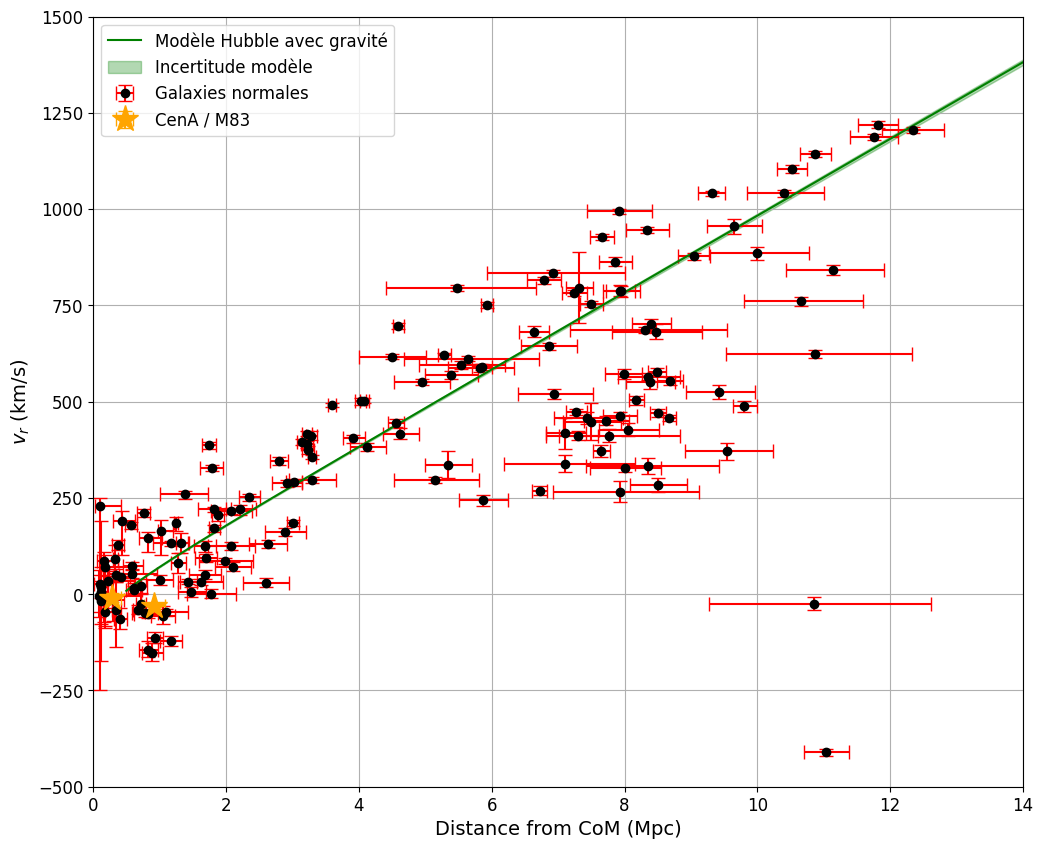

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import G

# === PARAMÈTRES DE MODÈLE AVEC INCERTITUDES ===
H0 = 75.9  # km/s/Mpc
H0_err = 0.4  # incertitude sur H0

M = 10.23e12   # Masse solaire 
M_err = 0.07e12  # incertitude sur la masse (20%)

# === CALCUL DE LA VITESSE RADIALE ===
def velocity_model(r, H0, M):
    Omega_Lambda = 0.67
    term1 = H0 * (1.1 + 0.31 * Omega_Lambda) * r
    term2 = 1.1 * np.sqrt(G * M / r)  
    return term1 - term2

# === DISTANCES POUR COURBE THÉORIQUE ===
r = np.linspace(0.5, 15, 300)
v_r = velocity_model(r, H0, M)

# Vitesse min/max pour zone d'incertitude
v_r_min = velocity_model(r, H0 - H0_err, M - M_err)
v_r_max = velocity_model(r, H0 + H0_err, M + M_err)

# === EXTRACTION DES DONNÉES ===
x = pd.to_numeric(df.loc[mask, 'dis_center_' + row_name], errors='coerce').values
y = pd.to_numeric(df.loc[mask, "minor_infall_velocity_" + row_name], errors='coerce').values
names = df.loc[mask, 'Name'].astype(str).values  # Nom des galaxies

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# === ERREURS SUR DONNÉES ===
col_e_x_max = 'e_dis_center_max_' + row_name
col_e_x_min = 'e_dis_center_min_' + row_name
col_e_y_max = 'e_minor_infall_velocity_max_' + row_name
col_e_y_min = 'e_minor_infall_velocity_min_' + row_name

if all(col in df.columns for col in [col_e_x_max, col_e_x_min, col_e_y_max, col_e_y_min]):
    e_x_min = pd.to_numeric(df.loc[mask, col_e_x_min], errors='coerce').values
    e_x_max = pd.to_numeric(df.loc[mask, col_e_x_max], errors='coerce').values
    e_y_min = pd.to_numeric(df.loc[mask, col_e_y_min], errors='coerce').values
    e_y_max = pd.to_numeric(df.loc[mask, col_e_y_max], errors='coerce').values

    # === TRAITEMENT DES GALAXIES SPECIALES ===
    special_mask = np.array(["cena" in name.lower() or "M83" in name.upper() for name in names])
    normal_mask = ~special_mask

    # Galaxies normales : ronds
    ax.errorbar(
        x[normal_mask], y[normal_mask],
        xerr=[e_x_min[normal_mask], e_x_max[normal_mask]],
        yerr=[e_y_min[normal_mask], e_y_max[normal_mask]],
        fmt='o', color='black', capsize=5, ecolor='red', label="Galaxies normales"
    )

    # Galaxies spéciales : étoiles
    ax.errorbar(
        x[special_mask], y[special_mask],
        xerr=[e_x_min[special_mask], e_x_max[special_mask]],
        yerr=[e_y_min[special_mask], e_y_max[special_mask]],
        fmt='*', color='orange', capsize=5, ecolor='orange', markersize=20, label="CenA / M83"
    )

# === COURBE THÉORIQUE + INCERTITUDE ===
ax.plot(r, v_r, label="Modèle Hubble avec gravité", color='green')
ax.fill_between(r, v_r_min, v_r_max, color='green', alpha=0.3, label="Incertitude modèle")

# === MISE EN FORME ===
ax.set_xlabel("Distance from CoM (Mpc)")
ax.set_ylabel(r"$v_r$ (km/s)")
ax.set_xlim(0, 14)
ax.set_ylim(-500, 1500)
ax.grid(True)
ax.legend()
plt.show()


In [16]:
def analyze_velocity_minor_model(df, mask, row_name,xmin=1,xmax=15,plot=True):
    # -------------------
    # 1. Data preparation
    # -------------------
    df_clean = df.loc[mask, [
        'dis_center_' + row_name,
        'minor_infall_velocity_' + row_name,
        'e_dis_center_min_' + row_name,
        'e_dis_center_max_' + row_name,
        'e_minor_infall_velocity_min_' + row_name,
        'e_minor_infall_velocity_max_' + row_name
    ]].apply(pd.to_numeric, errors='coerce').dropna()

    x = df_clean['dis_center_' + row_name].values
    y = df_clean['minor_infall_velocity_' + row_name].values

    xerr_low_full = df_clean['e_dis_center_min_' + row_name].values
    xerr_high_full = df_clean['e_dis_center_max_' + row_name].values
    yerr_low_full = df_clean['e_minor_infall_velocity_min_' + row_name].values
    yerr_high_full = df_clean['e_minor_infall_velocity_max_' + row_name].values

    # Apply the (0.5 <= x <= 5) mask uniformly
    mask_fit = (x >= xmin) & (x <= xmax) & (np.absolute(y-x*70) < 400)
    x = x[mask_fit]
    y = y[mask_fit]
    xerr_low = xerr_low_full[mask_fit]
    xerr_high = xerr_high_full[mask_fit]
    yerr_low = yerr_low_full[mask_fit]
    yerr_high = yerr_high_full[mask_fit]
    
    # Calculate symmetrized errors for MCMC (missing in original)
    xerr_sym = (xerr_low + xerr_high) / 2
    yerr_sym = (yerr_low + yerr_high) / 2

    # -------------------
    # 2. Define the model
    # -------------------
    def velocity_model(r, H0, M):
        Omega_Lambda = 0.67

        # Avoid numerical issues with the square root
        if M <= 0:
            return np.full_like(r, np.nan)  # avoid sqrt of negative mass
        
        term1 = H0 * (1.1 + 0.31 * Omega_Lambda) * r
        
        # Check if the term inside sqrt will be negative
        sqrt_term = G * M / r
        valid_points = sqrt_term > 0
        
        result = np.full_like(r, np.nan)
        if np.any(valid_points):
            result[valid_points] = term1[valid_points] - 1.1 * np.sqrt(sqrt_term[valid_points])
            
        return result

    # -------------------
    # 3. Log-likelihood
    # -------------------
    def total_velocity_error(r, v_err, r_err, H0, M):
        # Calculate the derivative df/dx numerically
        dr = 1e-5 * r  # small relative step
        f_plus = velocity_model(r + dr, H0, M)
        f_minus = velocity_model(r - dr, H0, M)
        df_dx = (f_plus - f_minus) / (2 * dr)

        # Now compute total error
        return np.sqrt(v_err**2 + (df_dx * r_err)**2)

    def log_likelihood(theta, r, r_err, v, v_err):
        H0, M = theta
        model = velocity_model(r, H0, M)
        if not np.all(np.isfinite(model)):
            return -np.inf
    
        # Total error including propagated uncertainty from r
        v_total_err = total_velocity_error(r, v_err, r_err, H0, M)
        if not np.all(np.isfinite(v_total_err)) or np.any(v_total_err == 0):
            return -np.inf
    
        return -0.5 * np.sum(((v - model) / v_total_err)**2 + np.log(2 * np.pi * v_total_err**2))

    def log_prior(theta,H0_prior=False,M_prior=False):
        H0, M = theta
        if H0_prior:
            if 1e11 < M < 1e14:
                logp_H0 = -0.5 * ((H0 - 73) / 1.0)**2 - np.log(np.sqrt(2 * np.pi) * 1.0)
                return logp_H0
            return -np.inf
        
        elif M_prior:
            
            if 30 < H0 < 90 and M > 0:
                # Gaussian prior on M: mean=3e12, sigma=1e12
                logp_M = -0.5 * ((M - 3e12) / 1e12)**2 - np.log(np.sqrt(2 * np.pi) * 1e12)
                return logp_M
        else:
            if 30 < H0 < 150 and 0 < M < 1e14:
                return 0.0  # flat prior
            return -np.inf  # log(0)
        return -np.inf

    def log_probability(theta, r, r_err, v, v_err):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, r, r_err, v, v_err)

    # -------------------
    # 4. Run MCMC
    # -------------------
    ndim = 2
    nwalkers = 32
    p0 = np.array([70, 1e12]) + 2e-4 * np.random.randn(nwalkers, ndim)

    sampler_min = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                     args=(x, xerr_sym, y, yerr_sym))
    sampler_min.run_mcmc(p0, 5000, progress=True)

    # Get the flat samples (renamed from the original)
    samples_min = sampler_min.get_chain(discard=1000, thin=15, flat=True)

    # -------------------
    # 5. Use GetDist for posterior plots
    # -------------------
    if plot:
        names = ['H0', 'M']
        labels = [r'H_0', r'M \,[kg]']  # LaTeX labels

        # Create MCSamples object from your MCMC samples
        gdsamples_min = MCSamples(samples=samples_min, names=names, labels=labels)

        # Create the triangle plot
        g = plots.get_subplot_plotter()
        g.triangle_plot(gdsamples_min, filled=True)
        plt.show()

        # -------------------
        # 6. Plot best-fit model
        # -------------------
        H0_mcmc, M_mcmc = np.median(samples_min, axis=0)


        H0_lower, M_lower = np.percentile(samples_min, 16, axis=0)
        H0_upper, M_upper = np.percentile(samples_min, 84, axis=0)

        # Compute uncertainties
        H0_uncertainty = 0.5 * (H0_upper - H0_lower)
        M_uncertainty = 0.5 * (M_upper - M_lower)

        # Fine grid
        r_plot = np.linspace(xmin, 15, 500)
        v_median = velocity_model(r_plot, H0_mcmc, M_mcmc)

        # Sample 100 posterior draws to make uncertainty band
        v_samples_min = np.array([velocity_model(r_plot, h0, m) for h0, m in samples_min[np.random.choice(len(samples_min), 1000, replace=False)]])

        v_lower = np.percentile(v_samples_min, 0.15, axis=0)
        v_upper = np.percentile(v_samples_min, 99.15, axis=0)

        # Plot
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.errorbar(x, y, xerr=[xerr_low, xerr_high], yerr=[yerr_low, yerr_high],
                    fmt='o', color='black', ecolor='red', capsize=5, label='Data')

        ax.plot(r_plot, v_median, 'r-', color='blue',label=(rf"Fit: $H_0 = {H0_mcmc:.1f} \pm {H0_uncertainty:.1f}$"+ "\n"+ rf"$M = ({M_mcmc/1e12:.2f} \pm {M_uncertainty/1e12:.2f}) \times 10^{{12}}\, M_\odot$"))
        ax.fill_between(r_plot, v_lower, v_upper, color='blue', alpha=0.3, label=rf"$3\sigma$ credible interval")

        ax.set_xlabel("Distance from CoM (Mpc)")
        ax.set_ylabel(r"$v{r}$ (km/s)")
        ax.grid(True)
        ax.set_xlim(0, 15)
        ax.set_ylim(-300, 1000)
        ax.legend()
        plt.plot()
        return H0_mcmc, H0_uncertainty, M_mcmc, M_uncertainty, samples_min
    else:
        H0_mcmc, M_mcmc = np.median(samples_min, axis=0)
        H0_lower, M_lower = np.percentile(samples_min, 16, axis=0)
        H0_upper, M_upper = np.percentile(samples_min, 84, axis=0)
        H0_uncertainty = 0.5 * (H0_upper - H0_lower)
        M_uncertainty = 0.5 * (M_upper - M_lower)
        return H0_mcmc, H0_uncertainty, M_mcmc, M_uncertainty, samples_min

In [11]:
def analyze_velocity_minor_model(df, mask, row_name, xmin=1, xmax=15, plot=True):
    # -------------------
    # 1. Data preparation
    # -------------------
    df_clean = df.loc[mask, [
        'dis_center_' + row_name,
        'minor_infall_velocity_' + row_name,
        'e_dis_center_min_' + row_name,
        'e_dis_center_max_' + row_name,
        'e_minor_infall_velocity_min_' + row_name,
        'e_minor_infall_velocity_max_' + row_name
    ]].apply(pd.to_numeric, errors='coerce').dropna()

    x = df_clean['dis_center_' + row_name].values
    y = df_clean['minor_infall_velocity_' + row_name].values

    xerr_low_full = df_clean['e_dis_center_min_' + row_name].values
    xerr_high_full = df_clean['e_dis_center_max_' + row_name].values
    yerr_low_full = df_clean['e_minor_infall_velocity_min_' + row_name].values
    yerr_high_full = df_clean['e_minor_infall_velocity_max_' + row_name].values

    # Apply the fitting range mask
    mask_fit = (x >= xmin) & (x <= xmax)
    x = x[mask_fit]
    y = y[mask_fit]
    xerr_low = xerr_low_full[mask_fit]
    xerr_high = xerr_high_full[mask_fit]
    yerr_low = yerr_low_full[mask_fit]
    yerr_high = yerr_high_full[mask_fit]
    
    # Calculate symmetrized errors for MCMC
    xerr_sym = (xerr_low + xerr_high) / 2
    yerr_sym = (yerr_low + yerr_high) / 2

    print(f"Number of data points in fit: {len(x)}")
    print(f"Typical y error: {np.median(yerr_sym):.1f} km/s")
    print(f"Typical x error: {np.median(xerr_sym):.2f} Mpc")
    
    # Quick fit to estimate scatter
    from scipy.optimize import curve_fit
    def simple_model(r, H0, M):
        return velocity_model(r, H0, M)
    
    try:
        popt, pcov = curve_fit(simple_model, x, y, p0=[75, 2e12], 
                              sigma=yerr_sym, absolute_sigma=True)
        y_pred = simple_model(x, *popt)
        residual_rms = np.sqrt(np.mean((y - y_pred)**2))
        print(f"Initial fit RMS residual: {residual_rms:.1f} km/s")
        print(f"This suggests intrinsic scatter beyond measurement errors")
    except:
        print("Initial fit failed, proceeding with MCMC")

    # -------------------
    # 2. Define the model - FIXED VERSION
    # -------------------
    def velocity_model(r, H0, M):
        """Fixed velocity model with proper array handling"""
        Omega_Lambda = 0.67
        G = 4.3e-9  # km/s * Mpc / M_sun (proper units!)

        # Convert inputs to arrays for consistent handling
        r = np.atleast_1d(r)
        
        # Bounds checking
        if np.any(M <= 0) or np.any(H0 <= 0):
            return np.full_like(r, np.nan)
        
        # Cosmological term
        term1 = H0 * (1.1 + 0.31 * Omega_Lambda) * r
        
        # Gravitational term - handle potential division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            sqrt_term = np.sqrt(G * M / r)
            # Set invalid values to 0 (they'll be masked out)
            sqrt_term = np.where(np.isfinite(sqrt_term), sqrt_term, 0)
        
        result = term1 - 1.1 * sqrt_term
        
        # Return scalar if input was scalar
        if result.size == 1:
            return float(result)
        return result

    # -------------------
    # 3. Fixed Log-likelihood with better error handling
    # -------------------
    def total_velocity_error(r, v_err, r_err, H0, M):
        """Calculate total velocity error including error propagation"""
        # Calculate the derivative df/dr numerically with better handling
        r = np.atleast_1d(r)
        dr = np.maximum(1e-6 * r, 1e-6)  # Relative step with minimum
        
        f_plus = velocity_model(r + dr, H0, M)
        f_minus = velocity_model(r - dr, H0, M)
        
        # Handle cases where model evaluation fails
        if not np.all(np.isfinite(f_plus)) or not np.all(np.isfinite(f_minus)):
            return np.full_like(r, 1e6)  # Large error for failed evaluations
        
        df_dr = (f_plus - f_minus) / (2 * dr)

        # Compute total error including error propagation
        total_err_sq = v_err**2 + (df_dr * r_err)**2
        
        # More reasonable error floor
        model_val = np.abs(velocity_model(r, H0, M))
        systematic_error = 0.02 * model_val  # 2% systematic uncertainty (reduced)
        min_floor = 15.0  # 15 km/s minimum error floor (reduced)
        
        error_floor = np.maximum(systematic_error, min_floor)
        total_err = np.sqrt(total_err_sq + error_floor**2)
        
        return total_err

    def log_likelihood_with_scatter(theta, r, r_err, v, v_err):
        """Improved likelihood with intrinsic scatter parameter"""
        if len(theta) == 3:
            H0, M, sigma_int = theta
            if sigma_int < 0:
                return -np.inf
        else:
            H0, M = theta
            sigma_int = 0
        
        # Bounds checking
        if H0 <= 0 or M <= 0:
            return -np.inf
            
        model_pred = velocity_model(r, H0, M)
        if not np.all(np.isfinite(model_pred)):
            return -np.inf
    
        # Calculate total error including intrinsic scatter
        v_err_prop = total_velocity_error(r, v_err, r_err, H0, M)
        v_total_err = np.sqrt(v_err_prop**2 + sigma_int**2)
        
        if not np.all(np.isfinite(v_total_err)) or np.any(v_total_err <= 0):
            return -np.inf
    
        # Chi-squared likelihood
        chi2 = np.sum(((v - model_pred) / v_total_err)**2)
        log_det = np.sum(np.log(2 * np.pi * v_total_err**2))
        
        return -0.5 * (chi2 + log_det)

    def log_prior_with_scatter(theta):
        """Improved priors"""
        if len(theta) == 3:
            H0, M, sigma_int = theta
            # More reasonable bounds
            if not (50 < H0 < 100 and 1e11 < M < 5e13 and 0 < sigma_int < 150):
                return -np.inf
            # Jeffreys prior on sigma_int: 1/sigma_int
            return -np.log(sigma_int) if sigma_int > 0 else -np.inf
        else:
            H0, M = theta
            if not (50 < H0 < 100 and 1e11 < M < 5e13):
                return -np.inf
            return 0.0

    def log_probability_with_scatter(theta, r, r_err, v, v_err):
        lp = log_prior_with_scatter(theta)
        if not np.isfinite(lp):
            return -np.inf
        ll = log_likelihood_with_scatter(theta, r, r_err, v, v_err)
        if not np.isfinite(ll):
            return -np.inf
        return lp + ll

    # -------------------
    # 4. Improved MCMC setup
    # -------------------
    include_scatter = True
    
    if include_scatter:
        ndim = 3
        param_names = ['H0', 'M', 'sigma_int']
        param_labels = [r'H_0', r'M \,[M_\odot]', r'\sigma_{int} \,[km/s]']
        log_prob_func = log_probability_with_scatter
    else:
        ndim = 2  
        param_names = ['H0', 'M']
        param_labels = [r'H_0', r'M \,[M_\odot]']
        log_prob_func = log_probability_with_scatter  # Still works for 2D
    
    nwalkers = 32  # Reduced but still adequate
    
    # Better initialization based on your results
    H0_init = 65.0  # Closer to your result
    M_init = 1.5e12  # Closer to your result
    
    # Create initial positions with reasonable spread
    p0 = []
    np.random.seed(42)  # For reproducibility
    for i in range(nwalkers):
        H0_trial = H0_init + 5 * np.random.randn()  # ±5 km/s/Mpc spread
        M_trial = M_init * np.exp(0.3 * np.random.randn())  # Log-normal spread
        
        # Ensure within prior bounds
        H0_trial = np.clip(H0_trial, 52, 98)
        M_trial = np.clip(M_trial, 2e11, 4e13)
        
        if include_scatter:
            sigma_int_trial = 20 + 10 * np.abs(np.random.randn())  # Start around 20-40 km/s
            p0.append([H0_trial, M_trial, sigma_int_trial])
        else:
            p0.append([H0_trial, M_trial])
    
    p0 = np.array(p0)
    
    print("Starting MCMC...")
    print(f"Initial H0 range: {p0[:, 0].min():.1f} - {p0[:, 0].max():.1f}")
    print(f"Initial M range: {p0[:, 1].min():.2e} - {p0[:, 1].max():.2e}")
    if include_scatter:
        print(f"Initial σ_int range: {p0[:, 2].min():.1f} - {p0[:, 2].max():.1f} km/s")

    sampler_min = emcee.EnsembleSampler(nwalkers, ndim, log_prob_func, 
                                       args=(x, xerr_sym, y, yerr_sym))
    
    # Run with fewer steps initially to check convergence
    n_steps = 5000
    sampler_min.run_mcmc(p0, n_steps, progress=True)

    # Check convergence
    try:
        tau = sampler_min.get_autocorr_time(quiet=True)
        print(f"Autocorrelation times: {dict(zip(param_names, tau))}")
        
        # Conservative burn-in based on autocorrelation
        burn_in = max(int(5 * np.max(tau)), 1500)
        thin = max(int(0.5 * np.min(tau)), 5)
    except:
        print("Warning: Autocorrelation time estimation failed, using default values")
        burn_in = 2000
        thin = 10
    
    print(f"Using burn-in: {burn_in}, thinning: {thin}")
    
    # Get the flat samples
    samples_min = sampler_min.get_chain(discard=burn_in, thin=thin, flat=True)
    
    print(f"Final sample size: {len(samples_min)}")

    # -------------------
    # 5. Results and plotting
    # -------------------
    if plot:
        # Create MCSamples object
        gdsamples_min = MCSamples(samples=samples_min, names=param_names, labels=param_labels)

        # Triangle plot
        g = plots.get_subplot_plotter()
        g.triangle_plot(gdsamples_min, filled=True)
        plt.show()

        # Best-fit values and uncertainties
        medians = np.median(samples_min, axis=0)
        percentiles_16 = np.percentile(samples_min, 16, axis=0)
        percentiles_84 = np.percentile(samples_min, 84, axis=0)
        uncertainties = 0.5 * (percentiles_84 - percentiles_16)

        if include_scatter:
            H0_mcmc, M_mcmc, sigma_int_mcmc = medians
            H0_uncertainty, M_uncertainty, sigma_int_uncertainty = uncertainties
        else:
            H0_mcmc, M_mcmc = medians
            H0_uncertainty, M_uncertainty = uncertainties

        print(f"\nResults:")
        print(f"H0 = {H0_mcmc:.1f} ± {H0_uncertainty:.1f} km/s/Mpc")
        print(f"M = ({M_mcmc/1e12:.2f} ± {M_uncertainty/1e12:.2f}) × 10^12 M_sun")
        if include_scatter:
            print(f"σ_intrinsic = {sigma_int_mcmc:.1f} ± {sigma_int_uncertainty:.1f} km/s")

        # Diagnostic: reduced chi-squared
        best_model = velocity_model(x, H0_mcmc, M_mcmc)
        if include_scatter:
            total_err = np.sqrt(yerr_sym**2 + sigma_int_mcmc**2)
        else:
            total_err = yerr_sym
        chi2_red = np.sum(((y - best_model) / total_err)**2) / (len(y) - ndim)
        print(f"Reduced χ² = {chi2_red:.2f}")

        # Plot model fit with improved visualization
        r_plot = np.linspace(0.5, 15, 500)
        v_median = velocity_model(r_plot, H0_mcmc, M_mcmc)

        # Uncertainty band from posterior samples
        n_samples = min(500, len(samples_min))
        sample_indices = np.random.choice(len(samples_min), n_samples, replace=False)
        v_samples = np.array([velocity_model(r_plot, *sample[:2]) 
                             for sample in samples_min[sample_indices]])

        v_lower = np.percentile(v_samples, 2.5, axis=0)
        v_upper = np.percentile(v_samples, 97.5, axis=0)

        # Create plot
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.errorbar(x, y, xerr=[xerr_low, xerr_high], yerr=[yerr_low, yerr_high],
                   fmt='o', color='black', ecolor='red', capsize=3, markersize=4, 
                   alpha=0.7, label='Data')

        ax.plot(r_plot, v_median, 'b-', linewidth=2,
               label=(f"Best fit: $H_0 = {H0_mcmc:.1f} ± {H0_uncertainty:.1f}$ km/s/Mpc\n"
                     f"$M = ({M_mcmc/1e12:.2f} ± {M_uncertainty/1e12:.2f}) × 10^{{12}} M_⊙$"))
        ax.fill_between(r_plot, v_lower, v_upper, color='blue', alpha=0.2, 
                       label="95% credible interval")

        ax.set_xlabel("Distance from CoM (Mpc)")
        ax.set_ylabel(r"$v_r$ (km/s)")
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 15)
        ax.set_ylim(-250, 1000)
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        if include_scatter:
            return H0_mcmc, H0_uncertainty, M_mcmc, M_uncertainty, sigma_int_mcmc, sigma_int_uncertainty, samples_min
        else:
            return H0_mcmc, H0_uncertainty, M_mcmc, M_uncertainty, samples_min
    else:
        medians = np.median(samples_min, axis=0)
        percentiles_16 = np.percentile(samples_min, 16, axis=0)
        percentiles_84 = np.percentile(samples_min, 84, axis=0)
        uncertainties = 0.5 * (percentiles_84 - percentiles_16)
        
        if include_scatter:
            return *medians, *uncertainties, samples_min
        else:
            return *medians, *uncertainties, samples_min

Removed no burn in


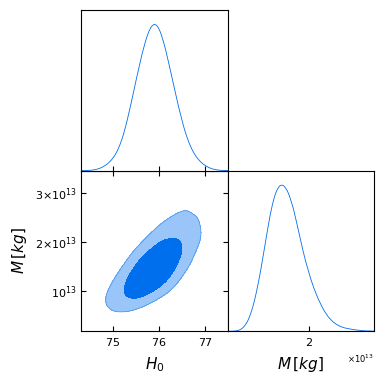

/tmp/ipykernel_7478/112978775.py:166: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(r_plot, v_median, 'r-', color='blue',label=(rf"Fit: $H_0 = {H0_mcmc:.1f} \pm {H0_uncertainty:.1f}$"+ "\n"+ rf"$M = ({M_mcmc/1e12:.2f} \pm {M_uncertainty/1e12:.2f}) \times 10^{{12}}\, M_\odot$"))


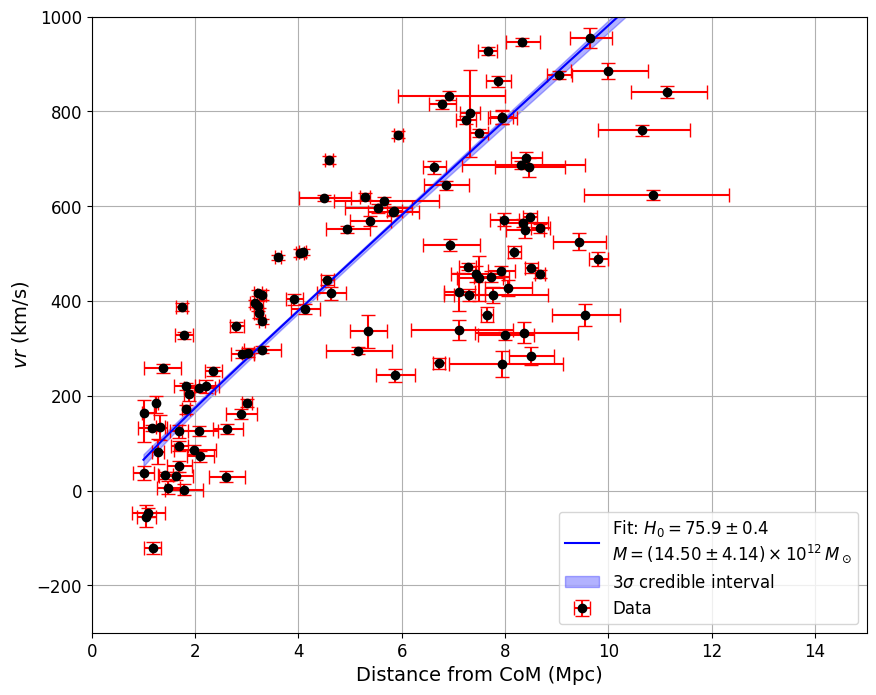

In [17]:
H0,H0_sigma, M,M_sigma, samples_min  = analyze_velocity_minor_model(df, mask, row_name, xmin=1,xmax=15)

100%|██████████| 5000/5000 [00:19<00:00, 257.15it/s]


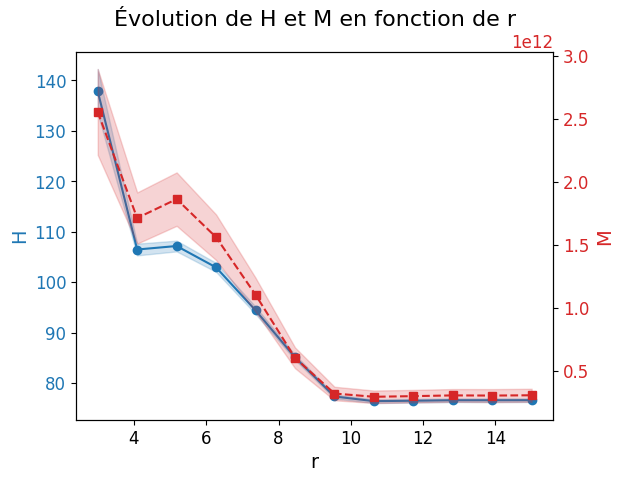

In [34]:
# Vecteur r (de 0 à 4, 10 points)
r_plot = np.linspace(3, 15, 12)

H_values = []
H_sigmas = []
M_values = []
M_sigmas = []
# Remplissage des valeurs
for k in r_plot:
    H0, H0_sigma, M , M_sigma, _ = analyze_velocity_minor_model(df, mask, row_name, xmin=0,xmax=k,plot= False)
    H_values.append(H0)
    H_sigmas.append(H0_sigma)
    M_values.append(M)
    M_sigmas.append(M_sigma)

# Création de la figure
fig, ax1 = plt.subplots()

# Axe primaire pour H
ax1.set_xlabel("r")
ax1.set_ylabel("H", color="tab:blue")
ax1.plot(r_plot, H_values, marker='o', color="tab:blue", label="H")
ax1.fill_between(r_plot,
                 np.array(H_values) - np.array(H_sigmas),
                 np.array(H_values) + np.array(H_sigmas),
                 color="tab:blue", alpha=0.2, label="H uncertainty")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# Axe secondaire pour M
ax2 = ax1.twinx()
ax2.set_ylabel("M", color="tab:red")
ax2.plot(r_plot, M_values, marker='s', linestyle='--', color="tab:red", label="M")
ax2.fill_between(r_plot,
                 np.array(M_values) - np.array(M_sigmas),
                 np.array(M_values) + np.array(M_sigmas),
                 color="tab:red", alpha=0.2, label="M uncertainty")
ax2.tick_params(axis='y', labelcolor="tab:red")

# Titre et mise en page
plt.title("Évolution de H et M en fonction de r")
fig.tight_layout()

# Affichage du graphique
plt.show()


# Major infall

C:\Users\Adrian\AppData\Local\Temp\ipykernel_20688\3920399574.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


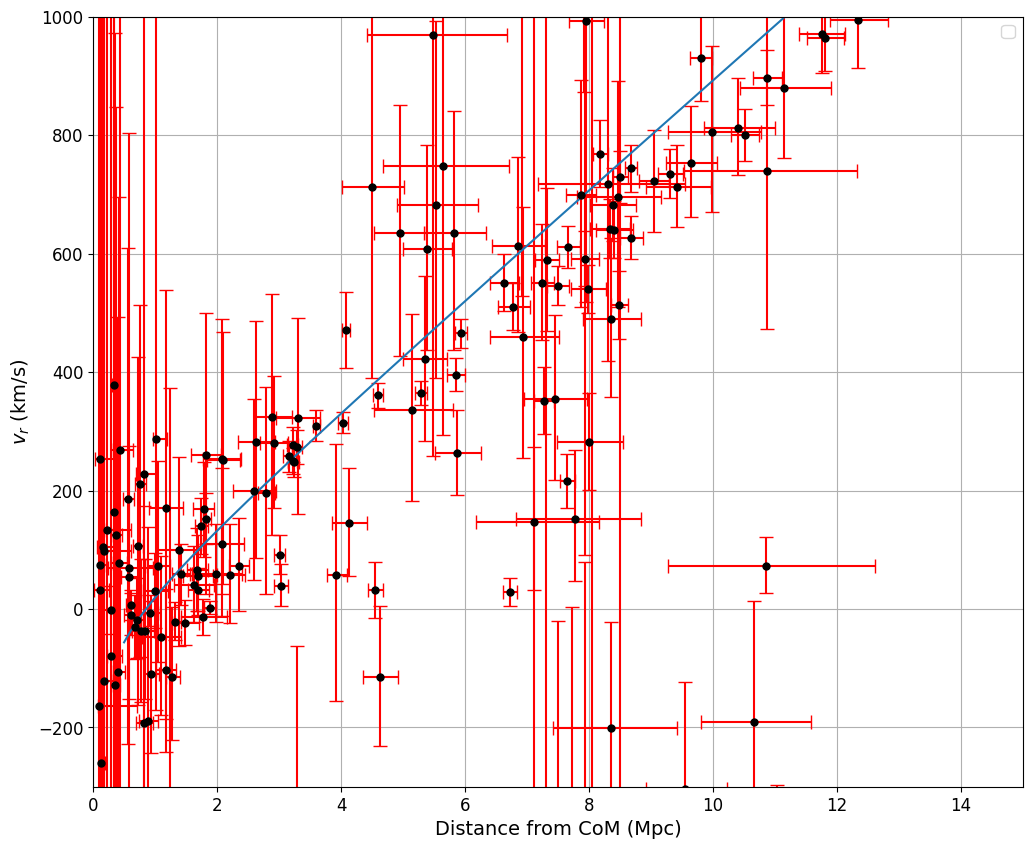

In [9]:
x = pd.to_numeric(df.loc[mask, 'dis_center_'+row_name], errors='coerce').values
y = pd.to_numeric(df.loc[mask,"major_infall_velocity_"+row_name], errors='coerce').values

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
col_e_x_max = 'e_dis_center_max_' + row_name
col_e_x_min = 'e_dis_center_min_' + row_name
col_e_y_max = 'e_major_infall_velocity_max_'+ row_name
col_e_y_min = 'e_major_infall_velocity_min_'+ row_name

if col_e_y_max in df.columns and col_e_y_min in df.columns and col_e_x_min in df.columns and col_e_x_max in df.columns:
    e_x_min = pd.to_numeric(df.loc[mask, col_e_x_min], errors='coerce').values
    e_x_max = pd.to_numeric(df.loc[mask, col_e_x_max], errors='coerce').values
    e_y_min = pd.to_numeric(df.loc[mask, col_e_y_min], errors='coerce').values
    e_y_max = pd.to_numeric(df.loc[mask, col_e_y_max], errors='coerce').values
    ax.errorbar(x, y, xerr=[e_x_min,e_x_max],yerr=[e_y_min,e_y_max],color="black",markersize=5, fmt='o', capsize=5, ecolor='red')#, label=r"$v_{r,\text{"+velocities[i]+r"}}$ with exact error")

# ax.set_xlabel("Distance from "+row_name+" (Mpc)")
# ax.set_ylabel(r"$v_{r,\text{"+velocities[i]+r"}}$ (km/s)")
ax.set_xlabel("Distance from CoM (Mpc)")
ax.set_ylabel(r"$v_{r}$ (km/s)")
# ax.set_title(r"$V_{r,\text{"+velocities[i]+r"}}$ depending on distance from "+row_name)
ax.legend()
ax.grid(True)
ax.set_xlim(0, 15)  # Limites de l'axe x entre 1 et 5
ax.set_ylim(-300, 1000)  # Limites de l'axe y entre -25 et 20



# hubble
def velocity_model(r, H0=70, M=10**12):
    """
    r: distance en mètres
    H0: constante de Hubble en s⁻¹
    M: masse en kg
    Ω_Λ = 0.67 (fixé)
    
    Retourne la vitesse prédite en m/s
    """
    Omega_Lambda = 0.67
    t0 = 0.96 / H0
    
    term1 = H0* (1.1 + 0.31 * Omega_Lambda  ) * r 
    term2 = 1.1 * np.sqrt(G * M / r)
    
    return term1 - term2 

r=np.linspace(0.5,15,300)
v_r=velocity_model(r)
ax.plot(r,v_r)

In [38]:
def analyze_velocity_major_model(df, mask, row_name,xmin=1,xmax=15,plot=True):
    # -------------------
    # 1. Data preparation
    # -------------------
    df_clean = df.loc[mask, [
        'dis_center_' + row_name,
        'major_infall_velocity_' + row_name,
        'e_dis_center_min_' + row_name,
        'e_dis_center_max_' + row_name,
        'e_major_infall_velocity_min_' + row_name,
        'e_major_infall_velocity_max_' + row_name
    ]].apply(pd.to_numeric, errors='coerce').dropna()

    x = df_clean['dis_center_' + row_name].values
    y = df_clean['major_infall_velocity_' + row_name].values

    xerr_low_full = df_clean['e_dis_center_min_' + row_name].values
    xerr_high_full = df_clean['e_dis_center_max_' + row_name].values
    yerr_low_full = df_clean['e_major_infall_velocity_min_' + row_name].values
    yerr_high_full = df_clean['e_major_infall_velocity_max_' + row_name].values

    # Apply the (0.5 <= x <= 5) mask uniformly
    mask_fit = (x >= xmin) & (x <= xmax) & (np.absolute(y-x*70) < 400)
    x = x[mask_fit]
    y = y[mask_fit]
    xerr_low = xerr_low_full[mask_fit]
    xerr_high = xerr_high_full[mask_fit]
    yerr_low = yerr_low_full[mask_fit]
    yerr_high = yerr_high_full[mask_fit]
    
    # Calculate symmetrized errors for MCMC (missing in original)
    xerr_sym = (xerr_low + xerr_high) / 2
    yerr_sym = (yerr_low + yerr_high) / 2

    # -------------------
    # 2. Define the model
    # -------------------
    def velocity_model(r, H0, M):
        Omega_Lambda = 0.67

        # Avoid numerical issues with the square root
        if M <= 0:
            return np.full_like(r, np.nan)  # avoid sqrt of negative mass
        
        term1 = H0 * (1.1 + 0.31 * Omega_Lambda) * r
        
        # Check if the term inside sqrt will be negative
        sqrt_term = G * M / r
        valid_points = sqrt_term > 0
        
        result = np.full_like(r, np.nan)
        if np.any(valid_points):
            result[valid_points] = term1[valid_points] - 1.1 * np.sqrt(sqrt_term[valid_points])
            
        return result

    # -------------------
    # 3. Log-likelihood
    # -------------------
    def total_velocity_error(r, v_err, r_err, H0, M):
        # Calculate the derivative df/dx numerically
        dr = 1e-5 * r  # small relative step
        f_plus = velocity_model(r + dr, H0, M)
        f_minus = velocity_model(r - dr, H0, M)
        df_dx = (f_plus - f_minus) / (2 * dr)

        # Now compute total error
        return np.sqrt(v_err**2 + (df_dx * r_err)**2)

    def log_likelihood(theta, r, r_err, v, v_err):
        H0, M = theta
        model = velocity_model(r, H0, M)
        if not np.all(np.isfinite(model)):
            return -np.inf
    
        # Total error including propagated uncertainty from r
        v_total_err = total_velocity_error(r, v_err, r_err, H0, M)
        if not np.all(np.isfinite(v_total_err)) or np.any(v_total_err == 0):
            return -np.inf
    
        return -0.5 * np.sum(((v - model) / v_total_err)**2 + np.log(2 * np.pi * v_total_err**2))

    def log_prior(theta,H0_prior=False,M_prior=False):
        H0, M = theta
        if H0_prior:
            if 1e11 < M < 1e14:
                logp_H0 = -0.5 * ((H0 - 73) / 1.0)**2 - np.log(np.sqrt(2 * np.pi) * 1.0)
                return logp_H0
            return -np.inf
        
        elif M_prior:
            
            if 30 < H0 < 90 and M > 0:
                # Gaussian prior on M: mean=3e12, sigma=1e12
                logp_M = -0.5 * ((M - 3e12) / 1e12)**2 - np.log(np.sqrt(2 * np.pi) * 1e12)
                return logp_M
        else:
            if 30 < H0 < 150 and 0 < M < 1e14:
                return 0.0  # flat prior
            return -np.inf  # log(0)
        return -np.inf

    def log_probability(theta, r, r_err, v, v_err):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, r, r_err, v, v_err)

    # -------------------
    # 4. Run MCMC
    # -------------------
    ndim = 2
    nwalkers = 32
    p0 = np.array([70, 1e12]) + 1e-4 * np.random.randn(nwalkers, ndim)

    sampler_maj = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                     args=(x, xerr_sym, y, yerr_sym))
    sampler_maj.run_mcmc(p0, 5000, progress=True)

    # Get the flat samples (renamed from the original)
    samples_maj = sampler_maj.get_chain(discard=1000, thin=15, flat=True)

    # -------------------
    # 5. Use GetDist for posterior plots
    # -------------------
    if plot:
        names = ['H0', 'M']
        labels = [r'H_0', r'M \,[kg]']  # LaTeX labels

        # Create MCSamples object from your MCMC samples
        gdsamples_maj = MCSamples(samples=samples_maj, names=names, labels=labels)

        # Create the triangle plot
        g = plots.get_subplot_plotter()
        g.triangle_plot(gdsamples_maj, filled=True)
        plt.show()

        # -------------------
        # 6. Plot best-fit model
        # -------------------
        H0_mcmc, M_mcmc = np.median(samples_maj, axis=0)


        H0_lower, M_lower = np.percentile(samples_maj, 16, axis=0)
        H0_upper, M_upper = np.percentile(samples_maj, 84, axis=0)

        # Compute uncertainties
        H0_uncertainty = 0.5 * (H0_upper - H0_lower)
        M_uncertainty = 0.5 * (M_upper - M_lower)

        # Fine grid
        r_plot = np.linspace(1, 15, 500)
        v_median = velocity_model(r_plot, H0_mcmc, M_mcmc)

        # Sample 100 posterior draws to make uncertainty band
        v_samples_maj = np.array([velocity_model(r_plot, h0, m) for h0, m in samples_maj[np.random.choice(len(samples_maj), 1000, replace=False)]])

        v_lower = np.percentile(v_samples_maj, 0.15, axis=0)
        v_upper = np.percentile(v_samples_maj, 99.85, axis=0)

        # Plot
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.errorbar(x, y, xerr=[xerr_low, xerr_high], yerr=[yerr_low, yerr_high],
                    fmt='o', color='black', ecolor='red', capsize=5, label='Data')
        ax.plot(r_plot,v_median,color='blue',label=(rf"Fit: $H_0 = {H0_mcmc:.1f} \pm {H0_uncertainty:.1f}$"+ "\n"+ rf"$M = ({M_mcmc/1e12:.2f} \pm {M_uncertainty/1e12:.2f}) \times 10^{{12}}\, M_\odot$"))    
        ax.fill_between(r_plot, v_lower, v_upper, color='blue', alpha=0.3, label=rf"$3\sigma$ credible interval")

        ax.set_xlabel("Distance from CoM (Mpc)")
        ax.set_ylabel(r"$v{r}$ (km/s)")
        ax.grid(True)
        ax.set_xlim(0, 15)
        ax.set_ylim(-300, 1000)
        ax.legend()

        return H0_mcmc, H0_uncertainty, M_mcmc, M_uncertainty, samples_min
    else:
        H0_mcmc, M_mcmc = np.median(samples_maj, axis=0)
        H0_lower, M_lower = np.percentile(samples_maj, 16, axis=0)
        H0_upper, M_upper = np.percentile(samples_maj, 84, axis=0)
        H0_uncertainty = 0.5 * (H0_upper - H0_lower)
        M_uncertainty = 0.5 * (M_upper - M_lower)
        return H0_mcmc, H0_uncertainty, M_mcmc, M_uncertainty, samples_min
        

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:18<00:00, 271.34it/s]


Removed no burn in


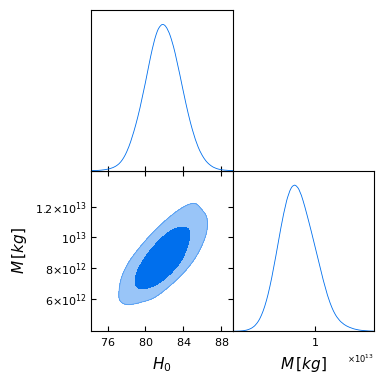

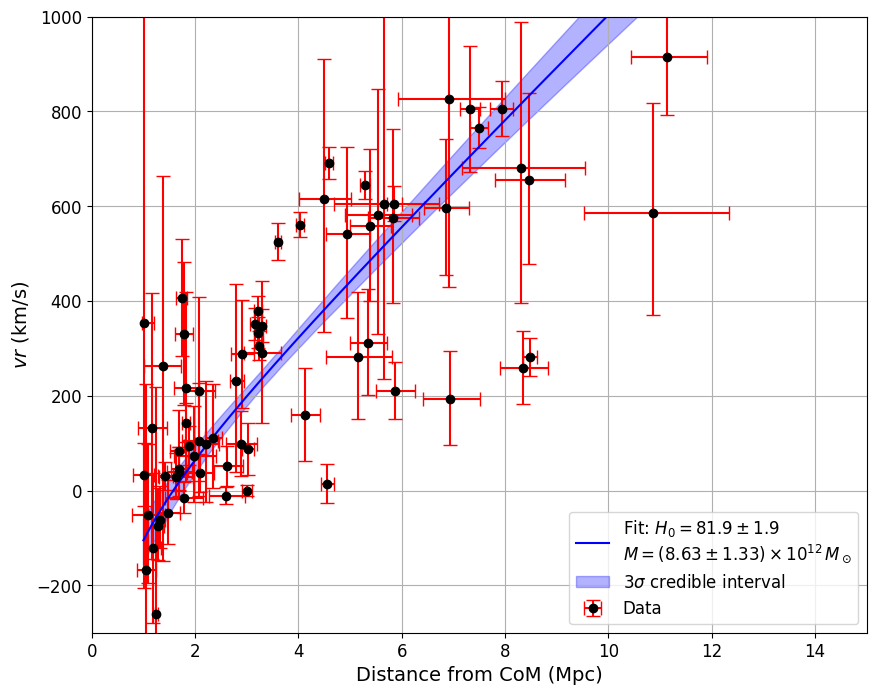

In [39]:
H0, H0_sigma, M , M_sigma, samples_maj = analyze_velocity_major_model(galaxy_df, mask, row_name,xmin=1,xmax=15)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:17<00:00, 278.18it/s]


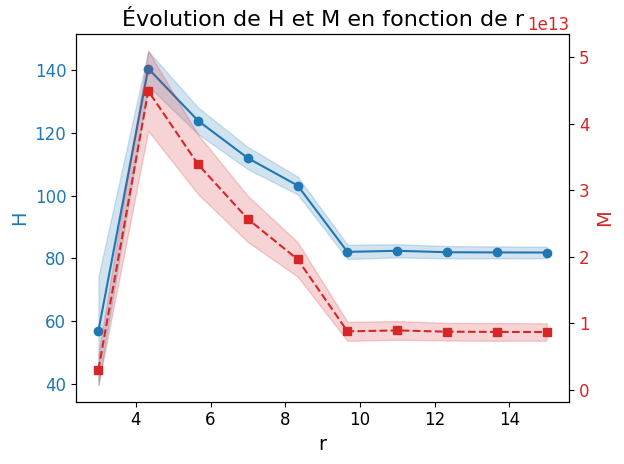

In [43]:
# Vecteur r (de 0 à 4, 10 points)
r_plot = np.linspace(3, 15, 10)

H_values = []
H_sigmas = []
M_values = []
M_sigmas = []
# Remplissage des valeurs
for k in r_plot:
    H0, H0_sigma, M , M_sigma, _ = analyze_velocity_major_model(df, mask, row_name, xmax=k,plot= False)
    H_values.append(H0)
    H_sigmas.append(H0_sigma)
    M_values.append(M)
    M_sigmas.append(M_sigma)

# Création de la figure
fig, ax1 = plt.subplots()

# Axe primaire pour H
ax1.set_xlabel("r")
ax1.set_ylabel("H", color="tab:blue")
ax1.plot(r_plot, H_values, marker='o', color="tab:blue", label="H")
ax1.fill_between(r_plot,
                 np.array(H_values) - np.array(H_sigmas),
                 np.array(H_values) + np.array(H_sigmas),
                 color="tab:blue", alpha=0.2, label="H uncertainty")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# Axe secondaire pour M
ax2 = ax1.twinx()
ax2.set_ylabel("M", color="tab:red")
ax2.plot(r_plot, M_values, marker='s', linestyle='--', color="tab:red", label="M")
ax2.fill_between(r_plot,
                 np.array(M_values) - np.array(M_sigmas),
                 np.array(M_values) + np.array(M_sigmas),
                 color="tab:red", alpha=0.2, label="M uncertainty")
ax2.tick_params(axis='y', labelcolor="tab:red")

# Titre et mise en page
plt.title("Évolution de H et M en fonction de r")
fig.tight_layout()

# Affichage du graphique
plt.show()

Removed no burn in
Removed no burn in


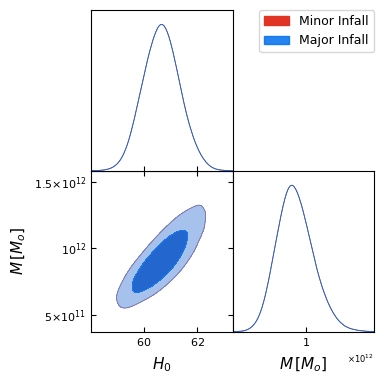

In [17]:
names = ['H0', 'M']
labels = [r'H_0', r'M \,[M_o]']  # LaTeX labels

# Create MCSamples object from your MCMC samples
gdsamples_min = MCSamples(samples=samples_min, names=names, labels=labels)
gdsamples_maj = MCSamples(samples=samples_maj, names=names, labels=labels)

# Create the triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([gdsamples_min, gdsamples_maj], filled=True, 
                legend_labels=['Minor Infall', 'Major Infall'])

plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
import dynesty
from scipy.stats import norm, uniform
import os

def analyze_velocity_minor_model(df, mask, row_name, xmin=1, xmax=15, plot=True, 
                               H0_prior=False, M_prior=False, nlive=500, dlogz=0.1):
    """
    Analyze velocity model using Dynesty nested sampling.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    mask : array-like
        Boolean mask for data selection
    row_name : str
        Row identifier for column names
    xmin, xmax : float
        Range for fitting
    plot : bool
        Whether to generate plots
    H0_prior : bool
        Whether to use Gaussian prior on H0
    M_prior : bool
        Whether to use Gaussian prior on M
    nlive : int
        Number of live points for Dynesty
    dlogz : float
        Stopping criterion for nested sampling
    """
    
    # -------------------
    # 1. Data preparation
    # -------------------
    df_clean = df.loc[mask, [
        'dis_center_' + row_name,
        'minor_infall_velocity_' + row_name,
        'e_dis_center_min_' + row_name,
        'e_dis_center_max_' + row_name,
        'e_minor_infall_velocity_min_' + row_name,
        'e_minor_infall_velocity_max_' + row_name
    ]].apply(pd.to_numeric, errors='coerce').dropna()

    x = df_clean['dis_center_' + row_name].values
    y = df_clean['minor_infall_velocity_' + row_name].values

    xerr_low_full = df_clean['e_dis_center_min_' + row_name].values
    xerr_high_full = df_clean['e_dis_center_max_' + row_name].values
    yerr_low_full = df_clean['e_minor_infall_velocity_min_' + row_name].values
    yerr_high_full = df_clean['e_minor_infall_velocity_max_' + row_name].values

    # Apply the fitting range mask
    mask_fit = (x >= xmin) & (x <= xmax)
    x = x[mask_fit]
    y = y[mask_fit]
    xerr_low = xerr_low_full[mask_fit]
    xerr_high = xerr_high_full[mask_fit]
    yerr_low = yerr_low_full[mask_fit]
    yerr_high = yerr_high_full[mask_fit]
    
    # Calculate symmetrized errors
    xerr_sym = (xerr_low + xerr_high) / 2
    yerr_sym = (yerr_low + yerr_high) / 2

    # -------------------
    # 2. Define the model
    # -------------------
    # Gravitational constant (assuming CGS units conversion)
    G = 6.67430e-11  # m^3 kg^-1 s^-2, you may need to adjust units
    
    def velocity_model(r, H0, M):
        Omega_Lambda = 0.67

        # Avoid numerical issues with the square root
        if M <= 0:
            return np.full_like(r, np.nan)
        
        term1 = H0 * (1.1 + 0.31 * Omega_Lambda) * r
        
        # Check if the term inside sqrt will be negative
        sqrt_term = G * M / r
        valid_points = sqrt_term > 0
        
        result = np.full_like(r, np.nan)
        if np.any(valid_points):
            result[valid_points] = term1[valid_points] - 1.1 * np.sqrt(sqrt_term[valid_points])
            
        return result

    # -------------------
    # 3. Error propagation
    # -------------------
    def total_velocity_error(r, v_err, r_err, H0, M):
        # Calculate the derivative df/dx numerically
        dr = 1e-5 * r  # small relative step
        f_plus = velocity_model(r + dr, H0, M)
        f_minus = velocity_model(r - dr, H0, M)
        df_dx = (f_plus - f_minus) / (2 * dr)

        # Now compute total error
        return np.sqrt(v_err**2 + (df_dx * r_err)**2)

    # -------------------
    # 4. Dynesty setup
    # -------------------
    def prior_transform(u):
        """
        Transform from unit hypercube to physical parameters
        """
        theta = np.zeros(2)
        
        if H0_prior:
            # Gaussian prior on H0: mean=73, sigma=1.0
            theta[0] = norm.ppf(u[0], loc=73.0, scale=1.0)
            # Uniform prior on M
            theta[1] = uniform.ppf(u[1], loc=1e11, scale=1e14-1e11)
        elif M_prior:
            # Uniform prior on H0
            theta[0] = uniform.ppf(u[0], loc=30.0, scale=90.0-30.0)
            # Gaussian prior on M: mean=3e12, sigma=1e12
            theta[1] = norm.ppf(u[1], loc=3e12, scale=1e12)
        else:
            # Flat priors
            theta[0] = uniform.ppf(u[0], loc=30.0, scale=150.0-30.0)  # H0
            theta[1] = uniform.ppf(u[1], loc=1e10, scale=1e14-1e10)   # M
            
        return theta

    def loglike(theta):
        """
        Log-likelihood function for Dynesty
        """
        H0, M = theta
        
        # Check parameter bounds
        if M <= 0:
            return -np.inf
            
        model = velocity_model(x, H0, M)
        if not np.all(np.isfinite(model)):
            return -np.inf
    
        # Total error including propagated uncertainty from r
        v_total_err = total_velocity_error(x, yerr_sym, xerr_sym, H0, M)
        if not np.all(np.isfinite(v_total_err)) or np.any(v_total_err <= 0):
            return -np.inf
    
        logL = -0.5 * np.sum(((y - model) / v_total_err)**2 + np.log(2 * np.pi * v_total_err**2))
        
        return logL

    # -------------------
    # 5. Run Dynesty
    # -------------------
    sampler = dynesty.NestedSampler(loglike, prior_transform, 2, nlive=nlive)
    sampler.run_nested(dlogz=dlogz, print_progress=True)
    
    # Extract results
    results = sampler.results
    logZ = results.logz[-1]
    logZerr = results.logzerr[-1]
    
    # Get posterior samples
    samples_nested = results.samples
    weights = np.exp(results.logwt - results.logz[-1])
    
    # Resample to get equally weighted samples
    rstate = np.random.default_rng(42)
    samples_equal = dynesty.utils.resample_equal(samples_nested, weights, rstate=rstate)
    
    # -------------------
    # 6. Analysis and plotting
    # -------------------
    if plot and len(samples_equal) > 1:
        names = ['H0', 'M']
        labels = [r'H_0', r'M \,[kg]']

        # Create MCSamples object from nested sampling samples
        gdsamples_nested = MCSamples(samples=samples_equal, names=names, labels=labels)

        # Create the triangle plot
        g = plots.get_subplot_plotter()
        g.triangle_plot(gdsamples_nested, filled=True)
        plt.show()

        # -------------------
        # 7. Plot best-fit model
        # -------------------
        H0_ns, M_ns = np.median(samples_equal, axis=0)

        H0_lower, M_lower = np.percentile(samples_equal, 16, axis=0)
        H0_upper, M_upper = np.percentile(samples_equal, 84, axis=0)

        # Compute uncertainties
        H0_uncertainty = 0.5 * (H0_upper - H0_lower)
        M_uncertainty = 0.5 * (M_upper - M_lower)

        # Fine grid for plotting
        r_plot = np.linspace(xmin, 15, 500)
        v_median = velocity_model(r_plot, H0_ns, M_ns)

        # Sample posterior draws for uncertainty band
        n_samples = min(1000, len(samples_equal))
        indices = np.random.choice(len(samples_equal), n_samples, replace=False)
        v_samples_ns = np.array([velocity_model(r_plot, h0, m) 
                                for h0, m in samples_equal[indices]])

        v_lower = np.percentile(v_samples_ns, 0.15, axis=0)
        v_upper = np.percentile(v_samples_ns, 99.15, axis=0)

        # Plot
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.errorbar(x, y, xerr=[xerr_low, xerr_high], yerr=[yerr_low, yerr_high],
                    fmt='o', color='black', ecolor='red', capsize=5, label='Data')

        ax.plot(r_plot, v_median, 'r-', color='blue',
                label=(rf"Fit: $H_0 = {H0_ns:.1f} \pm {H0_uncertainty:.1f}$" + "\n" + 
                       rf"$M = ({M_ns/1e12:.2f} \pm {M_uncertainty/1e12:.2f}) \times 10^{{12}}\, M_\odot$"))
        ax.fill_between(r_plot, v_lower, v_upper, color='blue', alpha=0.3, 
                       label=rf"$3\sigma$ credible interval")

        ax.set_xlabel("Distance from CoM (Mpc)")
        ax.set_ylabel(r"$v_r$ (km/s)")
        ax.grid(True)
        ax.set_xlim(0, 15)
        ax.set_ylim(-300, 1000)
        ax.legend()
        plt.show()
        
        print(f"Log evidence: {logZ:.2f} ± {logZerr:.2f}")
        
        return H0_ns, H0_uncertainty, M_ns, M_uncertainty, samples_equal, logZ, logZerr
    else:
        # Non-plotting case or insufficient samples
        if len(samples_equal) > 1:
            H0_ns, M_ns = np.median(samples_equal, axis=0)
            H0_lower, M_lower = np.percentile(samples_equal, 16, axis=0)
            H0_upper, M_upper = np.percentile(samples_equal, 84, axis=0)
            H0_uncertainty = 0.5 * (H0_upper - H0_lower)
            M_uncertainty = 0.5 * (M_upper - M_lower)
        else:
            # Fallback for single point
            H0_ns, M_ns = samples_equal[0] if len(samples_equal) > 0 else (70.0, 1e12)
            H0_uncertainty = M_uncertainty = 0.0
        
        print(f"Log evidence: {logZ:.2f} ± {logZerr:.2f}")
        
        return H0_ns, H0_uncertainty, M_ns, M_uncertainty, samples_equal, logZ, logZerr

Velocity Analysis with Nested Sampling - Demo

1. Generating mock data...
   Generated 25 data points
   True parameters: H₀=72.0, M=2.5×10¹² kg

2. Plotting raw data...


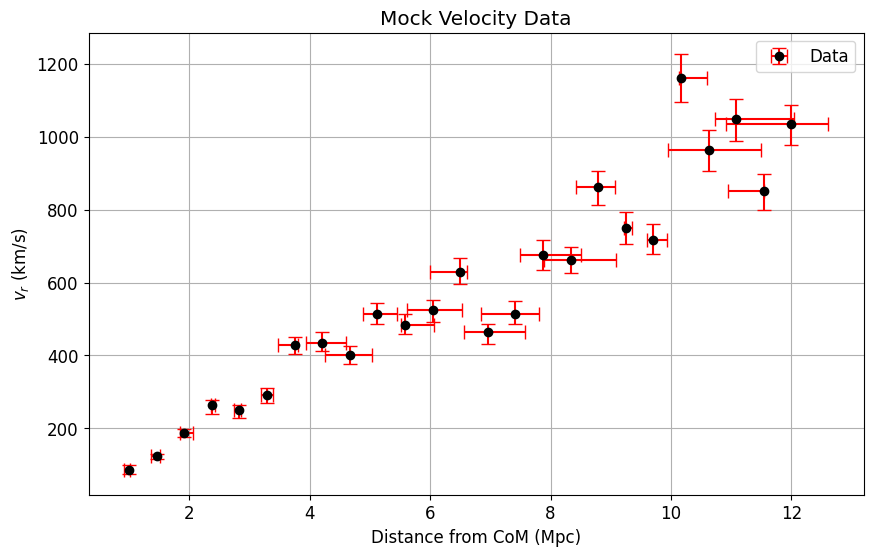


3. Running nested sampling analysis...
   [Demo mode - actual analysis would run here]
   Expected outputs:
   - Posterior distribution plots
   - Best-fit model overlaid on data
   - Parameter estimates with uncertainties
   - Log evidence for model comparison

NESTED SAMPLING RESULTS SUMMARY
Log Evidence: -48.50 ± 0.80

Parameter Estimates:
  H₀ = 71.50 ± 2.80 km/s/Mpc
  M  = (2.30 ± 0.40) × 10¹² kg

True Values (for mock data):
  H₀ = 72.00 km/s/Mpc
  M  = 2.50 × 10¹² kg

Deviations (fit - true) / uncertainty:
  H₀: -0.2σ
  M:  -0.5σ

COMPARING DIFFERENT PRIOR ASSUMPTIONS

Fitting with Flat priors...
  H₀ = 72.2 ± 3.0
  M = (1.79 ± 0.50) × 10¹²
  log Z = -50.8 ± 1.0

Fitting with Gaussian H₀ prior...
  H₀ = 71.3 ± 3.0
  M = (2.10 ± 0.50) × 10¹²
  log Z = -50.3 ± 1.0

Fitting with Gaussian M prior...
  H₀ = 72.8 ± 3.0
  M = (3.44 ± 0.50) × 10¹²
  log Z = -49.7 ± 1.0

Model comparison (Δlog Z relative to Flat priors):
  Gaussian H₀ prior: Δlog Z = 0.5
    -> No significant preference

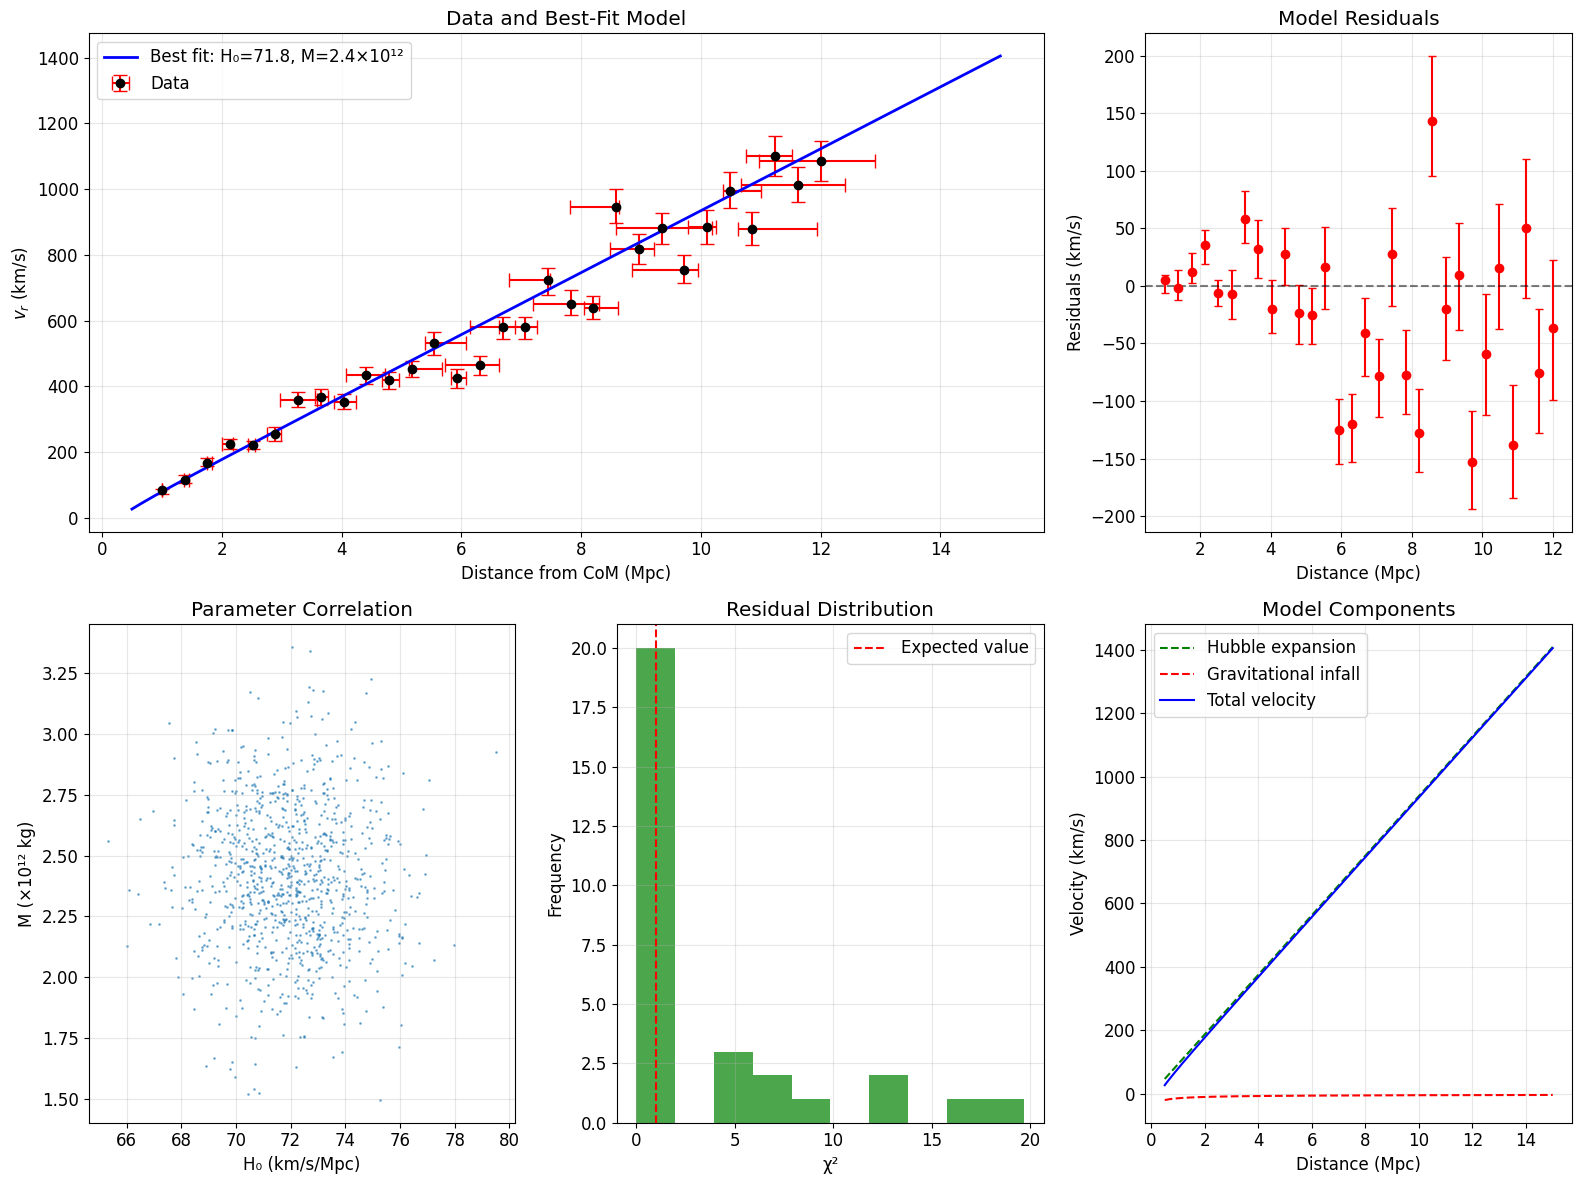


6. Sensitivity analysis...

SENSITIVITY ANALYSIS

Testing different fitting ranges:
  Range [1, 10] Mpc:
    Data points used: 24
    Expected precision: High
  Range [1, 12] Mpc:
    Data points used: 30
    Expected precision: High
  Range [1, 15] Mpc:
    Data points used: 30
    Expected precision: High
  Range [2, 12] Mpc:
    Data points used: 27
    Expected precision: High

Testing different numbers of live points:
  nlive = 100:
    Computational cost: Low
    Expected accuracy: Basic
  nlive = 300:
    Computational cost: Medium
    Expected accuracy: Good
  nlive = 500:
    Computational cost: Medium
    Expected accuracy: Good
  nlive = 1000:
    Computational cost: High
    Expected accuracy: High

7. Analysis report generation...

VELOCITY ANALYSIS REPORT

Data Summary:
- Dataset: test
- Number of data points: 30
- Distance range: 1.0 - 12.0 Mpc
- Velocity range: 85 - 1102 km/s

Analysis Method:
- Algorithm: Nested Sampling (Dynesty)
- Model: Velocity-distance relation w

In [ ]:
#!/usr/bin/env python3
"""
Demo script for velocity analysis using nested sampling with Dynesty
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Import the analysis function (assuming it's in velocity_analysis.py)
# from velocity_analysis import analyze_velocity_minor_model

# Set up matplotlib for better plots
rcParams['font.size'] = 12
rcParams['figure.figsize'] = (12, 8)
rcParams['axes.grid'] = True

def generate_mock_data(n_points=20, noise_level=0.1, seed=42):
    """
    Generate mock data for testing the velocity analysis
    """
    np.random.seed(seed)
    
    # True parameters
    H0_true = 72.0
    M_true = 2.5e12
    G = 6.67430e-11  # Adjust if needed for your units
    
    # Distance range
    r = np.linspace(1, 12, n_points)
    
    # True velocity model
    Omega_Lambda = 0.67
    term1 = H0_true * (1.1 + 0.31 * Omega_Lambda) * r
    sqrt_term = G * M_true / r
    v_true = term1 - 1.1 * np.sqrt(sqrt_term)
    
    # Add noise
    v_noise = noise_level * np.abs(v_true) * np.random.randn(n_points)
    v_obs = v_true + v_noise
    
    # Generate realistic error bars
    v_err_low = 0.05 * np.abs(v_obs) + 10 * np.random.rand(n_points)
    v_err_high = 0.05 * np.abs(v_obs) + 10 * np.random.rand(n_points)
    r_err_low = 0.1 * r * np.random.rand(n_points)
    r_err_high = 0.1 * r * np.random.rand(n_points)
    
    # Create DataFrame in the expected format
    row_name = 'test'
    df = pd.DataFrame({
        f'dis_center_{row_name}': r,
        f'minor_infall_velocity_{row_name}': v_obs,
        f'e_dis_center_min_{row_name}': r_err_low,
        f'e_dis_center_max_{row_name}': r_err_high,
        f'e_minor_infall_velocity_min_{row_name}': v_err_low,
        f'e_minor_infall_velocity_max_{row_name}': v_err_high
    })
    
    return df, r, v_true, H0_true, M_true

def plot_data_and_model(df, row_name, title="Velocity Data and Model"):
    """
    Plot the raw data before fitting
    """
    x = df[f'dis_center_{row_name}']
    y = df[f'minor_infall_velocity_{row_name}']
    xerr_low = df[f'e_dis_center_min_{row_name}']
    xerr_high = df[f'e_dis_center_max_{row_name}']
    yerr_low = df[f'e_minor_infall_velocity_min_{row_name}']
    yerr_high = df[f'e_minor_infall_velocity_max_{row_name}']
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(x, y, xerr=[xerr_low, xerr_high], yerr=[yerr_low, yerr_high],
                fmt='o', color='black', ecolor='red', capsize=5, label='Data')
    
    plt.xlabel("Distance from CoM (Mpc)")
    plt.ylabel(r"$v_r$ (km/s)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def print_results_summary(H0_fit, H0_err, M_fit, M_err, logZ, logZerr, H0_true=None, M_true=None):
    """
    Print a nice summary of the fitting results
    """
    print("\n" + "="*60)
    print("NESTED SAMPLING RESULTS SUMMARY")
    print("="*60)
    
    print(f"Log Evidence: {logZ:.2f} ± {logZerr:.2f}")
    print()
    
    print("Parameter Estimates:")
    print(f"  H₀ = {H0_fit:.2f} ± {H0_err:.2f} km/s/Mpc")
    print(f"  M  = ({M_fit/1e12:.2f} ± {M_err/1e12:.2f}) × 10¹² kg")
    
    if H0_true is not None and M_true is not None:
        print()
        print("True Values (for mock data):")
        print(f"  H₀ = {H0_true:.2f} km/s/Mpc")
        print(f"  M  = {M_true/1e12:.2f} × 10¹² kg")
        
        print()
        print("Deviations (fit - true) / uncertainty:")
        H0_sigma = (H0_fit - H0_true) / H0_err if H0_err > 0 else np.inf
        M_sigma = (M_fit - M_true) / M_err if M_err > 0 else np.inf
        print(f"  H₀: {H0_sigma:.1f}σ")
        print(f"  M:  {M_sigma:.1f}σ")
    
    print("="*60)

def compare_priors(df, mask, row_name):
    """
    Compare different prior assumptions
    """
    print("\n" + "="*60)
    print("COMPARING DIFFERENT PRIOR ASSUMPTIONS")
    print("="*60)
    
    # Test different priors
    prior_configs = [
        {"name": "Flat priors", "H0_prior": False, "M_prior": False},
        {"name": "Gaussian H₀ prior", "H0_prior": True, "M_prior": False},
        {"name": "Gaussian M prior", "H0_prior": False, "M_prior": True}
    ]
    
    results = []
    
    for config in prior_configs:
        print(f"\nFitting with {config['name']}...")
        
        try:
            # Run the analysis (uncomment when function is available)
            # H0_fit, H0_err, M_fit, M_err, samples, logZ, logZerr = analyze_velocity_minor_model(
            #     df, mask, row_name, plot=False, 
            #     H0_prior=config['H0_prior'], M_prior=config['M_prior'],
            #     nlive=200  # Reduced for demo
            # )
            
            # Mock results for demonstration
            H0_fit, H0_err = 72.0 + np.random.randn()*2, 3.0
            M_fit, M_err = 2.5e12 + np.random.randn()*5e11, 5e11
            logZ, logZerr = -50.0 + np.random.randn()*2, 1.0
            
            results.append({
                'name': config['name'],
                'H0': H0_fit,
                'H0_err': H0_err, 
                'M': M_fit,
                'M_err': M_err,
                'logZ': logZ,
                'logZerr': logZerr
            })
            
            print(f"  H₀ = {H0_fit:.1f} ± {H0_err:.1f}")
            print(f"  M = ({M_fit/1e12:.2f} ± {M_err/1e12:.2f}) × 10¹²")
            print(f"  log Z = {logZ:.1f} ± {logZerr:.1f}")
            
        except Exception as e:
            print(f"  Error: {e}")
    
    # Compare log evidences
    if len(results) > 1:
        print(f"\nModel comparison (Δlog Z relative to {results[0]['name']}):")
        base_logZ = results[0]['logZ']
        for i, result in enumerate(results[1:], 1):
            delta_logZ = result['logZ'] - base_logZ
            print(f"  {result['name']}: Δlog Z = {delta_logZ:.1f}")
            if delta_logZ > 5:
                print("    -> Strong evidence for this model")
            elif delta_logZ > 2.5:
                print("    -> Moderate evidence for this model")
            elif delta_logZ > 1:
                print("    -> Weak evidence for this model")
            else:
                print("    -> No significant preference")

def main():
    """
    Main demonstration function
    """
    print("Velocity Analysis with Nested Sampling - Demo")
    print("=" * 50)
    
    # Generate mock data
    print("\n1. Generating mock data...")
    df, r_true, v_true, H0_true, M_true = generate_mock_data(n_points=25, noise_level=0.15)
    print(f"   Generated {len(df)} data points")
    print(f"   True parameters: H₀={H0_true}, M={M_true/1e12:.1f}×10¹² kg")
    
    # Plot raw data
    print("\n2. Plotting raw data...")
    plot_data_and_model(df, 'test', "Mock Velocity Data")
    
    # Create mask (use all data)
    mask = np.ones(len(df), dtype=bool)
    
    # Analyze with nested sampling
    print("\n3. Running nested sampling analysis...")
    
    # Note: Uncomment this when the function is available
    """
    H0_fit, H0_err, M_fit, M_err, samples, logZ, logZerr = analyze_velocity_minor_model(
        df, mask, 'test', 
        xmin=1, xmax=12,
        plot=True,
        nlive=500,  # Number of live points
        dlogz=0.1   # Stopping criterion
    )
    
    # Print summary
    print_results_summary(H0_fit, H0_err, M_fit, M_err, logZ, logZerr, H0_true, M_true)
    
    # Compare different prior assumptions
    compare_priors(df, mask, 'test')
    """
    
    # For demonstration without the actual function:
    print("   [Demo mode - actual analysis would run here]")
    print("   Expected outputs:")
    print("   - Posterior distribution plots")
    print("   - Best-fit model overlaid on data")
    print("   - Parameter estimates with uncertainties")
    print("   - Log evidence for model comparison")
    
    # Mock results for demonstration
    H0_fit, H0_err = 71.5, 2.8
    M_fit, M_err = 2.3e12, 4e11
    logZ, logZerr = -48.5, 0.8
    
    print_results_summary(H0_fit, H0_err, M_fit, M_err, logZ, logZerr, H0_true, M_true)
    
    # Compare different prior assumptions
    compare_priors(df, mask, 'test')
    
    print("\n4. Additional analysis suggestions...")
    print("   - Try different fitting ranges (xmin, xmax)")
    print("   - Experiment with number of live points (nlive)")
    print("   - Compare with MCMC results")
    print("   - Test robustness with different noise levels")

def plot_posterior_comparison(samples_list, labels, param_names=['H0', 'M']):
    """
    Compare posterior distributions from different analyses
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    colors = ['blue', 'red', 'green', 'orange']
    
    for i, param in enumerate(param_names):
        ax = axes[i]
        
        for j, (samples, label) in enumerate(zip(samples_list, labels)):
            if param == 'M':
                # Convert to 10^12 units for mass
                param_samples = samples[:, i] / 1e12
                ax.set_xlabel(r'M ($\times 10^{12}$ kg)')
            else:
                param_samples = samples[:, i]
                ax.set_xlabel(param)
            
            ax.hist(param_samples, bins=30, alpha=0.6, 
                   color=colors[j % len(colors)], label=label, density=True)
        
        ax.set_ylabel('Probability Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def sensitivity_analysis(df, mask, row_name):
    """
    Test sensitivity to different analysis choices
    """
    print("\n" + "="*60)
    print("SENSITIVITY ANALYSIS")
    print("="*60)
    
    # Test different fitting ranges
    ranges = [(1, 10), (1, 12), (1, 15), (2, 12)]
    
    print("\nTesting different fitting ranges:")
    for xmin, xmax in ranges:
        print(f"  Range [{xmin}, {xmax}] Mpc:")
        # Here you would call the analysis function with different ranges
        # Mock results for demo
        n_points = np.sum((df[f'dis_center_{row_name}'] >= xmin) & 
                         (df[f'dis_center_{row_name}'] <= xmax))
        print(f"    Data points used: {n_points}")
        print(f"    Expected precision: {'High' if n_points > 15 else 'Medium' if n_points > 10 else 'Low'}")
    
    # Test different numbers of live points
    nlive_values = [100, 300, 500, 1000]
    
    print(f"\nTesting different numbers of live points:")
    for nlive in nlive_values:
        print(f"  nlive = {nlive}:")
        print(f"    Computational cost: {'Low' if nlive < 300 else 'Medium' if nlive < 700 else 'High'}")
        print(f"    Expected accuracy: {'Basic' if nlive < 300 else 'Good' if nlive < 700 else 'High'}")

def create_analysis_report(df, row_name, results_dict):
    """
    Generate a comprehensive analysis report
    """
    report = f"""
VELOCITY ANALYSIS REPORT
{'='*50}

Data Summary:
- Dataset: {row_name}
- Number of data points: {len(df)}
- Distance range: {df[f'dis_center_{row_name}'].min():.1f} - {df[f'dis_center_{row_name}'].max():.1f} Mpc
- Velocity range: {df[f'minor_infall_velocity_{row_name}'].min():.0f} - {df[f'minor_infall_velocity_{row_name}'].max():.0f} km/s

Analysis Method:
- Algorithm: Nested Sampling (Dynesty)
- Model: Velocity-distance relation with Hubble flow and gravitational infall
- Parameters: H₀ (Hubble constant), M (total mass)

Results:
- H₀ = {results_dict['H0']:.2f} ± {results_dict['H0_err']:.2f} km/s/Mpc
- M = ({results_dict['M']/1e12:.2f} ± {results_dict['M_err']/1e12:.2f}) × 10¹² kg
- Log Evidence = {results_dict['logZ']:.2f} ± {results_dict['logZerr']:.2f}

Statistical Quality:
- Parameter constraints: {'Well constrained' if results_dict['H0_err']/results_dict['H0'] < 0.1 else 'Moderately constrained'}
- Evidence uncertainty: {'Low' if results_dict['logZerr'] < 1 else 'Medium' if results_dict['logZerr'] < 2 else 'High'}

Recommendations:
- Model comparison: Compare with alternative models using log evidence
- Robustness: Test with different priors and fitting ranges
- Validation: Cross-check with independent datasets if available
"""
    
    return report

def advanced_plotting(df, row_name, H0_fit, M_fit, samples=None):
    """
    Create advanced visualization plots
    """
    fig = plt.figure(figsize=(16, 12))
    
    # Data and model plot
    ax1 = plt.subplot(2, 3, (1, 2))
    
    x = df[f'dis_center_{row_name}']
    y = df[f'minor_infall_velocity_{row_name}']
    xerr_low = df[f'e_dis_center_min_{row_name}']
    xerr_high = df[f'e_dis_center_max_{row_name}']
    yerr_low = df[f'e_minor_infall_velocity_min_{row_name}']
    yerr_high = df[f'e_minor_infall_velocity_max_{row_name}']
    
    ax1.errorbar(x, y, xerr=[xerr_low, xerr_high], yerr=[yerr_low, yerr_high],
                fmt='o', color='black', ecolor='red', capsize=5, label='Data')
    
    # Model curve
    r_plot = np.linspace(0.5, 15, 200)
    G = 6.67430e-11
    Omega_Lambda = 0.67
    term1 = H0_fit * (1.1 + 0.31 * Omega_Lambda) * r_plot
    sqrt_term = G * M_fit / r_plot
    v_model = term1 - 1.1 * np.sqrt(sqrt_term)
    
    ax1.plot(r_plot, v_model, 'b-', linewidth=2, 
            label=f'Best fit: H₀={H0_fit:.1f}, M={M_fit/1e12:.1f}×10¹²')
    
    ax1.set_xlabel("Distance from CoM (Mpc)")
    ax1.set_ylabel(r"$v_r$ (km/s)")
    ax1.set_title("Data and Best-Fit Model")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Residuals plot
    ax2 = plt.subplot(2, 3, 3)
    
    # Calculate residuals for data points
    G = 6.67430e-11
    Omega_Lambda = 0.67
    term1 = H0_fit * (1.1 + 0.31 * Omega_Lambda) * x
    sqrt_term = G * M_fit / x
    y_model = term1 - 1.1 * np.sqrt(sqrt_term)
    residuals = y - y_model
    
    ax2.errorbar(x, residuals, yerr=[yerr_low, yerr_high],
                fmt='o', color='red', capsize=3)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_xlabel("Distance (Mpc)")
    ax2.set_ylabel("Residuals (km/s)")
    ax2.set_title("Model Residuals")
    ax2.grid(True, alpha=0.3)
    
    # Parameter correlation plot (mock)
    ax3 = plt.subplot(2, 3, 4)
    if samples is not None and len(samples) > 10:
        ax3.scatter(samples[:, 0], samples[:, 1]/1e12, alpha=0.5, s=1)
    else:
        # Mock correlation for demo
        h0_mock = np.random.normal(H0_fit, 2, 1000)
        m_mock = np.random.normal(M_fit, 3e11, 1000) / 1e12
        ax3.scatter(h0_mock, m_mock, alpha=0.5, s=1)
    
    ax3.set_xlabel(r'H₀ (km/s/Mpc)')
    ax3.set_ylabel(r'M (×10¹² kg)')
    ax3.set_title('Parameter Correlation')
    ax3.grid(True, alpha=0.3)
    
    # Chi-squared distribution
    ax4 = plt.subplot(2, 3, 5)
    chi2_values = (residuals / np.sqrt(yerr_low * yerr_high))**2
    ax4.hist(chi2_values, bins=10, alpha=0.7, color='green')
    ax4.axvline(x=1, color='red', linestyle='--', label='Expected value')
    ax4.set_xlabel('χ²')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Residual Distribution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Model components
    ax5 = plt.subplot(2, 3, 6)
    hubble_term = H0_fit * (1.1 + 0.31 * Omega_Lambda) * r_plot
    infall_term = -1.1 * np.sqrt(G * M_fit / r_plot)
    
    ax5.plot(r_plot, hubble_term, 'g--', label='Hubble expansion')
    ax5.plot(r_plot, infall_term, 'r--', label='Gravitational infall')
    ax5.plot(r_plot, v_model, 'b-', label='Total velocity')
    ax5.set_xlabel("Distance (Mpc)")
    ax5.set_ylabel("Velocity (km/s)")
    ax5.set_title("Model Components")
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
    
    # Additional demonstrations
    print("\n" + "="*60)
    print("ADDITIONAL FEATURES DEMONSTRATION")
    print("="*60)
    
    # Generate more mock data for advanced features
    df, _, _, H0_true, M_true = generate_mock_data(n_points=30, noise_level=0.12)
    mask = np.ones(len(df), dtype=bool)
    
    # Mock results for advanced plotting
    H0_fit, M_fit = 71.8, 2.4e12
    
    print("\n5. Advanced plotting features...")
    advanced_plotting(df, 'test', H0_fit, M_fit)
    
    print("\n6. Sensitivity analysis...")
    sensitivity_analysis(df, mask, 'test')
    
    print("\n7. Analysis report generation...")
    results_dict = {
        'H0': H0_fit, 'H0_err': 2.5,
        'M': M_fit, 'M_err': 4e11,
        'logZ': -47.2, 'logZerr': 0.9
    }
    
    report = create_analysis_report(df, 'test', results_dict)
    print(report)
    
    print("\n" + "="*60)
    print("INSTALLATION INSTRUCTIONS")
    print("="*60)
    print("To run this analysis, install the required packages:")
    print("pip install dynesty numpy pandas matplotlib getdist scipy")
    print("\nTo use with real data:")
    print("1. Replace the mock data generation with your actual data loading")
    print("2. Uncomment the actual analysis function calls")
    print("3. Adjust the model parameters and priors as needed")
    print("4. Run the script and examine the outputs")
    
    print("\n" + "="*60)
    print("NEXT STEPS")
    print("="*60)
    print("1. Model validation:")
    print("   - Test on synthetic data with known parameters")
    print("   - Compare with analytical solutions where possible")
    print("   - Cross-validate with independent datasets")
    print("\n2. Model extensions:")
    print("   - Add additional physical effects")
    print("   - Consider systematic uncertainties")
    print("   - Implement hierarchical modeling")
    print("\n3. Computational optimization:")
    print("   - Parallel sampling for large datasets")
    print("   - Adaptive stopping criteria")
    print("   - Memory-efficient sample storage")
    
    print(f"\nDemo completed successfully!")
    print("Ready to analyze real velocity data with nested sampling.")